In [1]:
import os
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap
from tqdm import tqdm

import pandas as pd

c:\Users\ShivamSingh\miniconda3\envs\idh1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ShivamSingh\miniconda3\envs\idh1\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_df = pd.read_csv('D:\projects\slideflow\idh1_project\idh1_tumor_vs_normal_clean162_slides.csv')
data_df

,patient,slide,label
0,patient_0,AML_Box8_OT47,tumor_tissue
1,patient_1,AML_Box10_OT05,tumor_tissue
2,patient_2,AML_Box12_OT40,tumor_tissue
3,patient_3,AML_Box13_OT61,tumor_tissue
4,patient_4,AML_Box10_OT13,normal_tissue
...,...,...,...
157,patient_185,AML_Box14_OT22,tumor_tissue
158,patient_874,AML_Box8_OT13,tumor_tissue
159,patient_1093,AML_Box10_OT65,tumor_tissue
160,patient_1167,AML_Box11_OT37,tumor_tissue


In [5]:
ctrsnspath_dir = r'D:\projects\slideflow\idh1_project\feature_bags\bags_ctranspath'
ctranspath_feat_files = os.listdir(ctrsnspath_dir)
ctranspath_feat_files = [ i for i in ctranspath_feat_files if '.pt' in i]
ctranspath_feat_files

['AML_Box10_OT03.pt',
 'AML_Box10_OT04.pt',
 'AML_Box10_OT05.pt',
 'AML_Box10_OT06.pt',
 'AML_Box10_OT07.pt',
 'AML_Box10_OT08.pt',
 'AML_Box10_OT12.pt',
 'AML_Box10_OT13.pt',
 'AML_Box10_OT14.pt',
 'AML_Box10_OT16.pt',
 'AML_Box10_OT17.pt',
 'AML_Box10_OT19.pt',
 'AML_Box10_OT20.pt',
 'AML_Box10_OT21.pt',
 'AML_Box10_OT22.pt',
 'AML_Box10_OT23.pt',
 'AML_Box10_OT24.pt',
 'AML_Box10_OT25.pt',
 'AML_Box10_OT26.pt',
 'AML_Box10_OT27.pt',
 'AML_Box10_OT28.pt',
 'AML_Box10_OT30.pt',
 'AML_Box10_OT31.pt',
 'AML_Box10_OT32.pt',
 'AML_Box10_OT33.pt',
 'AML_Box10_OT34.pt',
 'AML_Box10_OT36.pt',
 'AML_Box10_OT37.pt',
 'AML_Box10_OT38.pt',
 'AML_Box10_OT48.pt',
 'AML_Box10_OT55.pt',
 'AML_Box10_OT63.pt',
 'AML_Box10_OT65.pt',
 'AML_Box10_OT79.pt',
 'AML_Box10_OT94.pt',
 'AML_Box11_OT09.pt',
 'AML_Box11_OT13.pt',
 'AML_Box11_OT15.pt',
 'AML_Box11_OT28.pt',
 'AML_Box11_OT31.pt',
 'AML_Box11_OT34.pt',
 'AML_Box11_OT37.pt',
 'AML_Box11_OT38.pt',
 'AML_Box11_OT44.pt',
 'AML_Box11_OT48.pt',
 'AML_Box1

In [13]:
x = torch.load(os.path.join(ctrsnspath_dir,ctranspath_feat_files[0]))
np.shape(x.numpy())

(1048, 768)

In [14]:
x = torch.load(os.path.join(ctrsnspath_dir,ctranspath_feat_files[1]))
np.shape(x.numpy())

(6850, 768)

In [3]:
# Load the .pt files from a given directory
def load_features_from_directory(directory_path):
    all_features = []
    
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.pt'):  # Ensure only .pt files are processed
            file_path = os.path.join(directory_path, file_name)
            features = torch.load(file_path)
            all_features.append(features)
    
    # Concatenate all the features
    combined_features = torch.cat(all_features, dim=0).numpy()
    return combined_features


# Function to perform KMeans evaluation using Elbow and Silhouette scores
def evaluate_kmeans(features, max_clusters=10):
    inertia = []
    silhouette_scores = []
    cluster_range = range(2, max_clusters+1)

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(features)
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(features, labels))

    return cluster_range, inertia, silhouette_scores


# Plot Elbow and Silhouette scores
def plot_evaluation(cluster_range, inertia, silhouette_scores):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Elbow plot
    ax[0].plot(cluster_range, inertia, 'bo-', markersize=8, label='Inertia')
    ax[0].set_title('Elbow Method for Optimal K', fontsize=14)
    ax[0].set_xlabel('Number of Clusters', fontsize=12)
    ax[0].set_ylabel('Inertia', fontsize=12)
    ax[0].grid(True)

    # Silhouette score plot
    ax[1].plot(cluster_range, silhouette_scores, 'go-', markersize=8, label='Silhouette Score')
    ax[1].set_title('Silhouette Score for Optimal K', fontsize=14)
    ax[1].set_xlabel('Number of Clusters', fontsize=12)
    ax[1].set_ylabel('Silhouette Score', fontsize=12)
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()
    
    
# Perform UMAP for dimensionality reduction and visualization
def umap_visualization(features, labels):
    reducer = umap.UMAP(n_components=3, random_state=42)
    embedding = reducer.fit_transform(features)

    # 3D UMAP Visualization
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=labels, cmap='Spectral', s=5)

    # Adding legend and titles
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)
    plt.title('UMAP 3D projection of Patches', fontsize=14)
    plt.show()

In [4]:
ctrsnspath_dir = r'D:\projects\slideflow\idh1_project\feature_bags\bags_ctranspath'
features = load_features_from_directory(ctrsnspath_dir)

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

cluster_range, inertia, silhouette_scores = evaluate_kmeans(features_scaled, max_clusters=10)


KeyboardInterrupt: 

In [5]:
features_scaled

array([[-0.5077098 ,  1.0476242 ,  0.7327374 , ...,  1.444155  ,
         0.77580523,  0.18207495],
       [-0.5243861 , -1.0430392 ,  0.3766612 , ..., -0.21151824,
         0.8222736 , -0.98781425],
       [-0.48636314, -0.57086647,  0.2774413 , ...,  1.1380676 ,
         0.4859377 , -0.6714902 ],
       ...,
       [ 0.060903  , -2.9004066 ,  2.0600398 , ...,  0.26976088,
         0.41187912, -1.8000599 ],
       [-0.16915157, -4.6673384 ,  3.2792432 , ...,  2.206595  ,
         1.6131694 , -0.04202135],
       [-0.65963393, -2.1213863 ,  2.9401052 , ...,  1.2882109 ,
         0.15129504,  0.23440021]], dtype=float32)

In [2]:
outfile = 'D:\projects\slideflow\idh1_project\ctranspath_allWSI_features_scaled.npy'
# np.save(outfile, features_scaled)

In [3]:
features_scaled = np.load(outfile)
np.shape(features_scaled)

(2555422, 768)

In [ ]:
print('cluster_range, inertia, silhouette_scores:', cluster_range, inertia, silhouette_scores)

In [ ]:
# Plot the elbow and silhouette scores to determine the optimal number of clusters
plot_evaluation(cluster_range, inertia, silhouette_scores)

In [ ]:
# Main function
def main():
    # Specify the directory containing the .pt files
    input_directory = 'path_to_your_directory'  # Replace with your actual directory path

    # Load the feature data from all .pt files in the directory
    features = load_features_from_directory(input_directory)

    # Standardize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Perform KMeans evaluation
    cluster_range, inertia, silhouette_scores = evaluate_kmeans(features_scaled, max_clusters=10)

    # Plot the elbow and silhouette scores to determine the optimal number of clusters
    plot_evaluation(cluster_range, inertia, silhouette_scores)

    # Choose the optimal number of clusters (e.g., based on elbow or silhouette)
    optimal_k = 5  # Set based on your observation from plots

    # Perform KMeans clustering with the optimal number of clusters
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    labels = kmeans.fit_predict(features_scaled)

    # UMAP 3D visualization
    umap_visualization(features_scaled, labels)

In [9]:
optimal_k = 5  # Set based on your observation from plots

# Perform KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(features_scaled)


In [10]:
embedding = np.load('D:\projects\slideflow\idh1_project\ctranspath_allWSI_features_3dUMAPembedding.npy')

In [9]:
reducer = umap.UMAP(n_components=3, random_state=42, verbose=True)
embedding = reducer.fit_transform(features_scaled)

np.save('D:\projects\slideflow\idh1_project\ctranspath_allWSI_features_3dUMAPembedding.npy', embedding)



c:\Users\ShivamSingh\miniconda3\envs\idh1\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(n_components=3, n_jobs=1, random_state=42, verbose=True)
Thu Sep 26 10:01:50 2024 Construct fuzzy simplicial set
Thu Sep 26 10:01:56 2024 Finding Nearest Neighbors
Thu Sep 26 10:01:57 2024 Building RP forest with 64 trees
Thu Sep 26 10:22:50 2024 NN descent for 21 iterations
	 1  /  21
	 2  /  21
	 3  /  21
	 4  /  21
	Stopping threshold met -- exiting after 4 iterations
Thu Sep 26 10:28:23 2024 Finished Nearest Neighbor Search
Thu Sep 26 10:29:03 2024 Construct embedding


	completed  0  /  200 epochs


	completed  20  /  200 epochs


	completed  40  /  200 epochs


	completed  60  /  200 epochs


	completed  80  /  200 epochs


	completed  100  /  200 epochs


	completed  120  /  200 epochs


Epochs completed:  61%| ██████     122/200 [39:21]

	completed  140  /  200 epochs


	completed  160  /  200 epochs


Epochs completed:  81%| ████████   162/200 [53:04]


	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [1:06:36]


Thu Sep 26 11:42:45 2024 Finished embedding


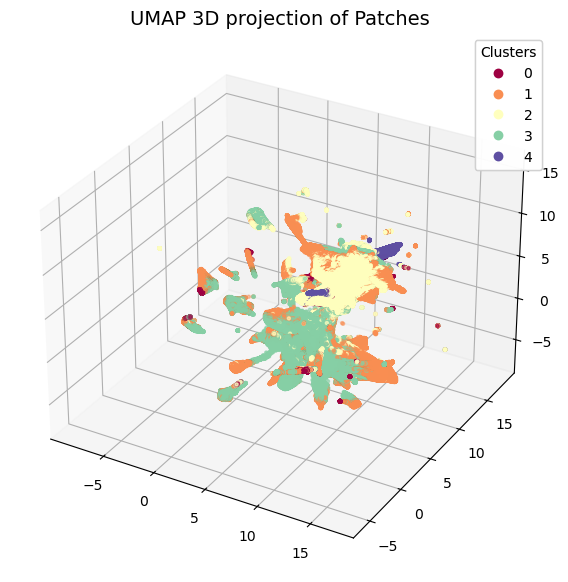

In [11]:
# 3D UMAP Visualization
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=labels, cmap='Spectral', s=5)

# Adding legend and titles
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.title('UMAP 3D projection of Patches', fontsize=14)
plt.show()

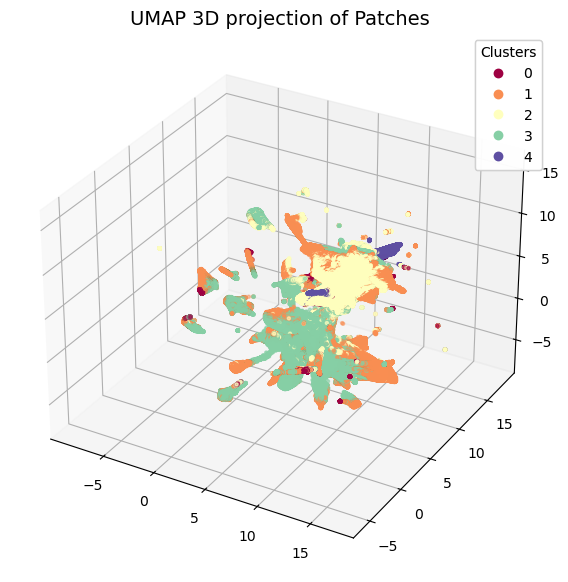

In [10]:
# 3D UMAP Visualization
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=labels, cmap='Spectral', s=5)

# Adding legend and titles
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.title('UMAP 3D projection of Patches', fontsize=14)
plt.show()

In [4]:
reducer_2d = umap.UMAP(n_components=2, random_state=42, verbose=True)
embedding_2d = reducer_2d.fit_transform(features_scaled)

np.save('D:\projects\slideflow\idh1_project\ctranspath_allWSI_features_2dUMAPembedding.npy', embedding_2d)

c:\Users\ShivamSingh\miniconda3\envs\idh1\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(n_jobs=1, random_state=42, verbose=True)
Thu Sep 26 11:55:02 2024 Construct fuzzy simplicial set
Thu Sep 26 11:55:07 2024 Finding Nearest Neighbors
Thu Sep 26 11:55:08 2024 Building RP forest with 64 trees
Thu Sep 26 12:16:56 2024 NN descent for 21 iterations
	 1  /  21
	 2  /  21
	 3  /  21
	 4  /  21
	Stopping threshold met -- exiting after 4 iterations
Thu Sep 26 12:22:18 2024 Finished Nearest Neighbor Search
Thu Sep 26 12:23:04 2024 Construct embedding


Epochs completed:   1%|            2/200 [00:03]

	completed  0  /  200 epochs


Epochs completed:  11%| █          22/200 [04:49]

	completed  20  /  200 epochs


Epochs completed:  20%| ██         41/200 [09:36]

	completed  40  /  200 epochs


Epochs completed:  30%| ███        61/200 [14:39]

	completed  60  /  200 epochs


Epochs completed:  40%| ████       81/200 [19:41]

	completed  80  /  200 epochs


Epochs completed:  50%| █████      101/200 [24:53]

	completed  100  /  200 epochs


Epochs completed:  60%| ██████     121/200 [29:36]

	completed  120  /  200 epochs


Epochs completed:  70%| ███████    141/200 [36:36]

	completed  140  /  200 epochs


Epochs completed:  80%| ████████   161/200 [42:34]

	completed  160  /  200 epochs


Epochs completed:  90%| █████████  181/200 [47:50]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [55:16]


Thu Sep 26 13:22:17 2024 Finished embedding


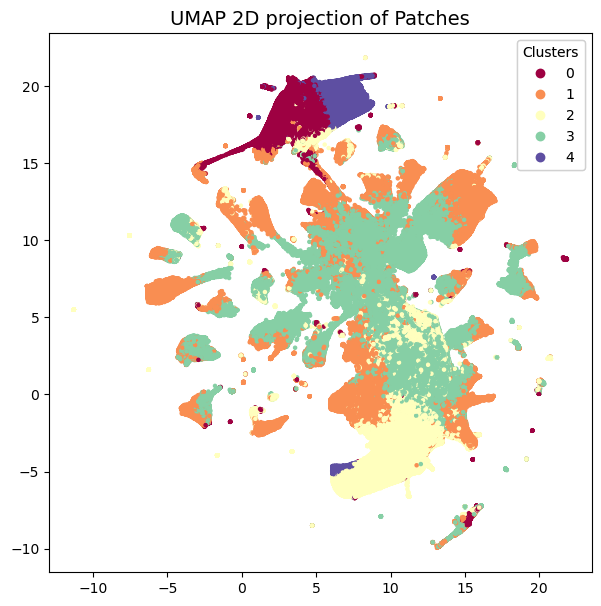

In [25]:
# 2D UMAP Visualization
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
scatter = ax.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=labels, cmap='Spectral', s=5)

# Adding legend and titles
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.title('UMAP 2D projection of Patches', fontsize=14)
plt.show()

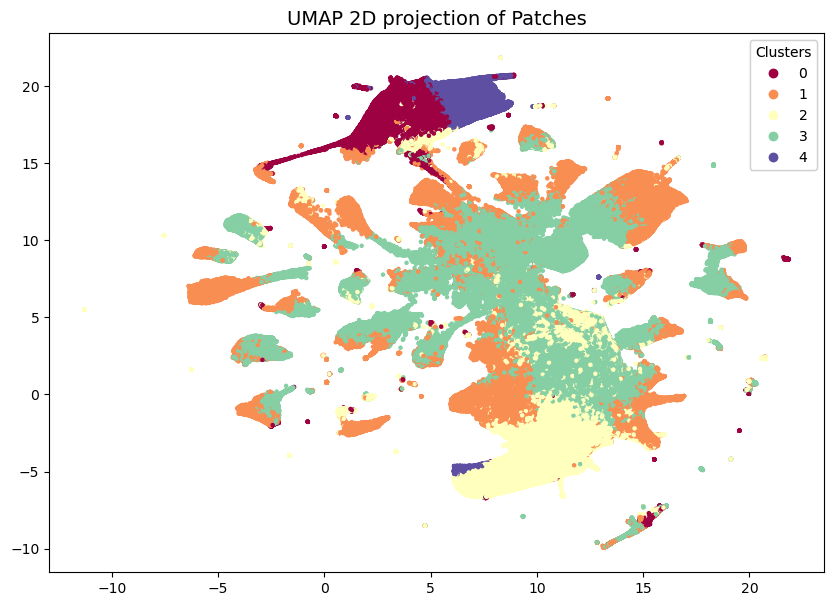

In [12]:
# 2D UMAP Visualization
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
scatter = ax.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=labels, cmap='Spectral', s=5)

# Adding legend and titles
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.title('UMAP 2D projection of Patches', fontsize=14)
plt.show()

In [14]:
np.shape(embedding_2d)

(2555422, 2)

In [15]:
optimal_k = 2  # Set based on your observation from plots

# Perform KMeans clustering with the optimal number of clusters
kmeans_K2 = KMeans(n_clusters=optimal_k, random_state=42)
labels_K2 = kmeans_K2.fit_predict(features_scaled)    


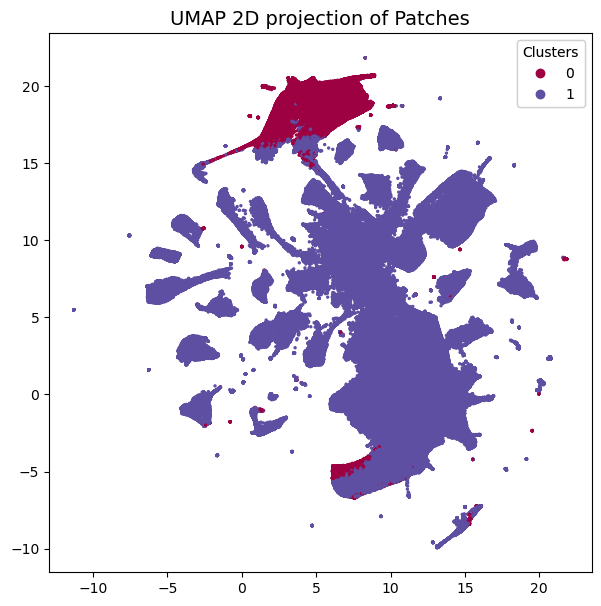

In [17]:
# 2D UMAP Visualization
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
scatter = ax.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=labels_K2, cmap='Spectral', s=2)

# Adding legend and titles
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.title('UMAP 2D projection of Patches', fontsize=14)
plt.show()

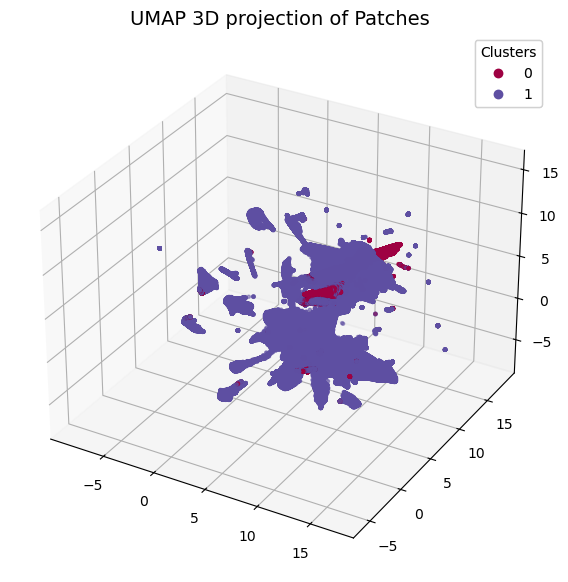

In [18]:
# 3D UMAP Visualization
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=labels_K2, cmap='Spectral', s=5)

# Adding legend and titles
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.title('UMAP 3D projection of Patches', fontsize=14)
plt.show()

In [19]:
optimal_k = 3  # Set based on your observation from plots

# Perform KMeans clustering with the optimal number of clusters
kmeans_K3 = KMeans(n_clusters=optimal_k, random_state=42)
labels_K3 = kmeans_K3.fit_predict(features_scaled)    


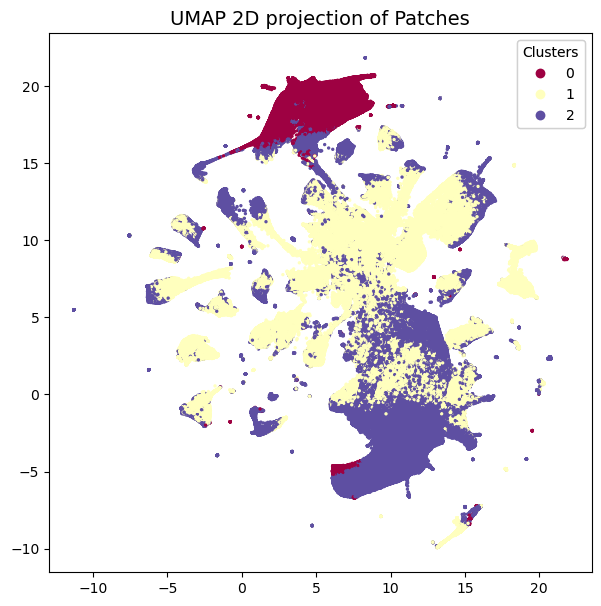

In [20]:
# 2D UMAP Visualization
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
scatter = ax.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=labels_K3, cmap='Spectral', s=2)

# Adding legend and titles
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.title('UMAP 2D projection of Patches', fontsize=14)
plt.show()

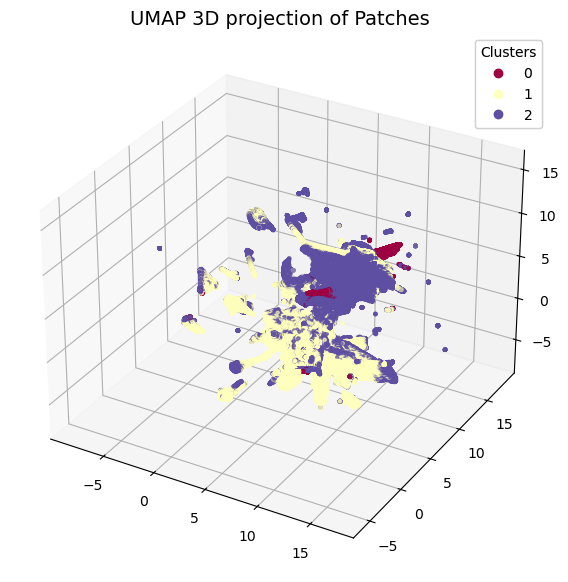

In [21]:
# 3D UMAP Visualization
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=labels_K3, cmap='Spectral', s=5)

# Adding legend and titles
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.title('UMAP 3D projection of Patches', fontsize=14)
plt.show()

In [22]:
optimal_k = 4  # Set based on your observation from plots

# Perform KMeans clustering with the optimal number of clusters
kmeans_K4 = KMeans(n_clusters=optimal_k, random_state=42)
labels_K4 = kmeans_K4.fit_predict(features_scaled)    


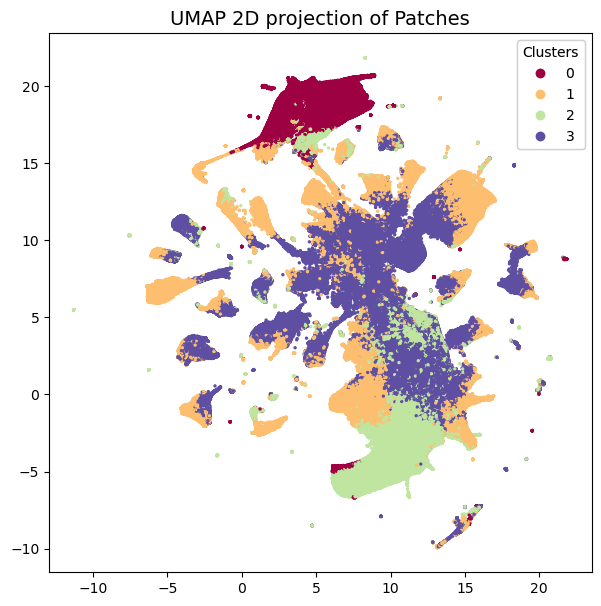

In [23]:
# 2D UMAP Visualization
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
scatter = ax.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=labels_K4, cmap='Spectral', s=2)

# Adding legend and titles
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.title('UMAP 2D projection of Patches', fontsize=14)
plt.show()

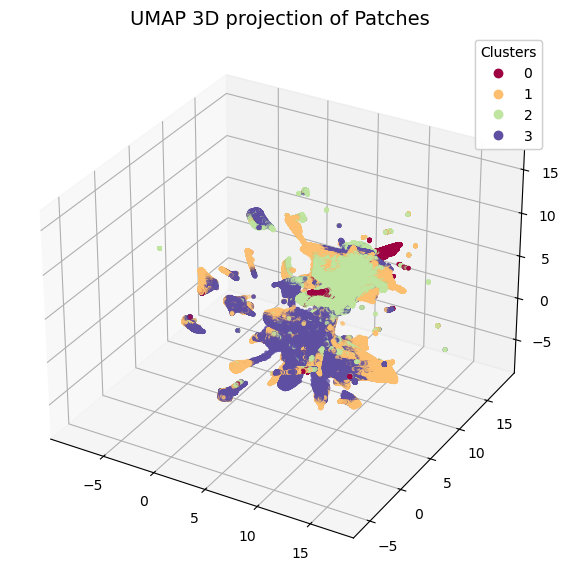

In [24]:
# 3D UMAP Visualization
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=labels_K4, cmap='Spectral', s=5)

# Adding legend and titles
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.title('UMAP 3D projection of Patches', fontsize=14)
plt.show()

In [34]:
label_df = pd.read_csv(r'D:\projects\slideflow\idh1_project\idh1_tumor_vs_normal_clean162_slides.csv')
label_df

,patient,slide,label
0,patient_0,AML_Box8_OT47,tumor_tissue
1,patient_1,AML_Box10_OT05,tumor_tissue
2,patient_2,AML_Box12_OT40,tumor_tissue
3,patient_3,AML_Box13_OT61,tumor_tissue
4,patient_4,AML_Box10_OT13,normal_tissue
...,...,...,...
157,patient_185,AML_Box14_OT22,tumor_tissue
158,patient_874,AML_Box8_OT13,tumor_tissue
159,patient_1093,AML_Box10_OT65,tumor_tissue
160,patient_1167,AML_Box11_OT37,tumor_tissue


In [31]:
bag_dir = r'D:\projects\slideflow\idh1_project\feature_bags\bags_ctranspath'

feature_bag_ctranspath = os.listdir(bag_dir)
feature_bag_ctranspath = [ i for i in feature_bag_ctranspath if i.endswith('.pt')]
feature_bag_ctranspath

['AML_Box10_OT03.pt',
 'AML_Box10_OT04.pt',
 'AML_Box10_OT05.pt',
 'AML_Box10_OT06.pt',
 'AML_Box10_OT07.pt',
 'AML_Box10_OT08.pt',
 'AML_Box10_OT12.pt',
 'AML_Box10_OT13.pt',
 'AML_Box10_OT14.pt',
 'AML_Box10_OT16.pt',
 'AML_Box10_OT17.pt',
 'AML_Box10_OT19.pt',
 'AML_Box10_OT20.pt',
 'AML_Box10_OT21.pt',
 'AML_Box10_OT22.pt',
 'AML_Box10_OT23.pt',
 'AML_Box10_OT24.pt',
 'AML_Box10_OT25.pt',
 'AML_Box10_OT26.pt',
 'AML_Box10_OT27.pt',
 'AML_Box10_OT28.pt',
 'AML_Box10_OT30.pt',
 'AML_Box10_OT31.pt',
 'AML_Box10_OT32.pt',
 'AML_Box10_OT33.pt',
 'AML_Box10_OT34.pt',
 'AML_Box10_OT36.pt',
 'AML_Box10_OT37.pt',
 'AML_Box10_OT38.pt',
 'AML_Box10_OT48.pt',
 'AML_Box10_OT55.pt',
 'AML_Box10_OT63.pt',
 'AML_Box10_OT65.pt',
 'AML_Box10_OT79.pt',
 'AML_Box10_OT94.pt',
 'AML_Box11_OT09.pt',
 'AML_Box11_OT13.pt',
 'AML_Box11_OT15.pt',
 'AML_Box11_OT28.pt',
 'AML_Box11_OT31.pt',
 'AML_Box11_OT34.pt',
 'AML_Box11_OT37.pt',
 'AML_Box11_OT38.pt',
 'AML_Box11_OT44.pt',
 'AML_Box11_OT48.pt',
 'AML_Box1

In [33]:
y = torch.load(os.path.join(bag_dir,feature_bag_ctranspath[0]))
np.shape(y.numpy())

(1048, 768)

In [37]:
# Sample path for demonstration (you should set your own path)
bag_dir = r'D:\projects\slideflow\idh1_project\feature_bags\bags_ctranspath'
# feature_bag_ctranspath = ['slide1_tensor.pt', 'slide2_tensor.pt', 'slide3_tensor.pt']  # Example file names

# Initialize lists to hold slide names and features
slide_names = []
features = []

# Iterate over each file in feature_bag_ctranspath
for slide in feature_bag_ctranspath:
    # Load the tensor from the file
    y = torch.load(os.path.join(bag_dir, slide))
    # Convert to NumPy array
    feature_array = y.numpy().flatten()  # Flatten to shape (768,)
    
    # Append each feature with the corresponding slide name
    for feature in feature_array:
        slide_names.append(slide.split('.')[0])  # Store the slide name for each feature
        features.append(feature)    # Store the individual feature

# Create a DataFrame with slide names and features
y_df = pd.DataFrame({
    'slide': slide_names,
    'feature': features
})

y_df

MemoryError: 